In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import openai
from numpy import nan
import re
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import scipy.stats as stats

%matplotlib inline

In [2]:
dsscdb = pd.read_csv("imputed_dsscdb.csv", index_col=0)
dsscdb

,VOC,JSC,FF,PCE,Electrolyte,Molecule SMILE,Exposure time (h),Solar simulator at 1.5G (mW/cm2),Dye loading (nmol/cm2),Semiconductor Type,Semiconductor Film Thickness (um),Semiconductor Scattering Layer Thickness (um),Used Co-sensitizer,Used Co-adsorbent,Co-adsorbent type,Co-adsorbent Conc. (mM),Active area (cm2)
0,687.0,10.79,0.70,5.19,Iodide_Triiodide,N#C/C(=C\c1ccc(cc1)N(c1ccccc1)CCCCCCN1c2ccccc2...,15.0,100.0,152.64,TiO2,12.0,0.0,0,0,None,0.0,0.250
1,790.0,6.90,0.47,2.60,Spiro-OMeTAD,N#C/C(=C\c1ccc(s1)c1ccc(s1)c1ccc(cc1)N(c1ccc(c...,5.0,100.0,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
2,835.0,7.70,0.49,3.10,Spiro-OMeTAD,N#C/C(=C\c1ccc(s1)c1ccc(cc1)N(c1ccc(cc1)/C=C/c...,5.0,100.0,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
3,800.0,6.40,0.43,2.20,Spiro-OMeTAD,CCN(c1ccc2c(c1)oc(=O)c(c2)/C=C/c1ccc(cc1)N(c1c...,5.0,100.0,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
4,651.0,10.30,0.75,5.00,Iodide_Triiodide,N#C/C(=C\c1ccc(s1)c1ccc(s1)c1ccc(cc1)N(c1ccc(c...,5.0,100.0,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,666.0,17.84,0.74,8.79,Iodide_Triiodide,S=C=N[Ru]12(N=C=S)(N3CCC(CC3C3N2CCC(C3)C(=O)[O...,24.0,100.0,152.64,TiO2,14.0,0.0,0,0,None,0.0,0.120
4422,651.0,9.93,0.70,4.52,Iodide_Triiodide,C(#N)/C(/C(=O)O)=C\C=1SC(=CC1)C=1C=CC=2N(C3=CC...,24.0,100.0,296.00,TiO2,14.0,0.0,0,0,None,0.0,0.120
4423,667.0,12.85,0.71,6.09,Iodide_Triiodide,CSC1=CC=C(C=C1)C=1C=C2SC=3C=C(C=CC3N(C2=CC1)CC...,24.0,100.0,224.00,TiO2,14.0,0.0,0,0,None,0.0,0.120
4424,659.0,12.46,0.69,5.65,Iodide_Triiodide,COC1=CC=C(C=C1)C=1C=C2SC=3C=C(C=CC3N(C2=CC1)CC...,24.0,100.0,187.00,TiO2,14.0,0.0,0,0,None,0.0,0.120


In [3]:
device_props = dsscdb[["VOC", "JSC", "FF", "PCE"]]
device_descs = dsscdb[["Exposure time (h)", "Solar simulator at 1.5G (mW/cm2)", "Electrolyte", 
                             "Dye loading (nmol/cm2)", 
                             "Semiconductor Type", 
                             "Semiconductor Film Thickness (um)", 
                             "Semiconductor Scattering Layer Thickness (um)",
                             "Used Co-sensitizer",
                             "Used Co-adsorbent",
                             "Co-adsorbent type",
                             "Co-adsorbent Conc. (mM)",
                             "Active area (cm2)"]]

In [4]:
device_descs

,Exposure time (h),Solar simulator at 1.5G (mW/cm2),Electrolyte,Dye loading (nmol/cm2),Semiconductor Type,Semiconductor Film Thickness (um),Semiconductor Scattering Layer Thickness (um),Used Co-sensitizer,Used Co-adsorbent,Co-adsorbent type,Co-adsorbent Conc. (mM),Active area (cm2)
0,15.0,100.0,Iodide_Triiodide,152.64,TiO2,12.0,0.0,0,0,None,0.0,0.250
1,5.0,100.0,Spiro-OMeTAD,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
2,5.0,100.0,Spiro-OMeTAD,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
3,5.0,100.0,Spiro-OMeTAD,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
4,5.0,100.0,Iodide_Triiodide,152.64,TiO2,8.0,5.0,0,0,None,0.0,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...
4421,24.0,100.0,Iodide_Triiodide,152.64,TiO2,14.0,0.0,0,0,None,0.0,0.120
4422,24.0,100.0,Iodide_Triiodide,296.00,TiO2,14.0,0.0,0,0,None,0.0,0.120
4423,24.0,100.0,Iodide_Triiodide,224.00,TiO2,14.0,0.0,0,0,None,0.0,0.120
4424,24.0,100.0,Iodide_Triiodide,187.00,TiO2,14.0,0.0,0,0,None,0.0,0.120


In [5]:
electrolyte_ohe = pd.get_dummies(device_descs["Electrolyte"], prefix="Electrolyte", sparse=True)
electrolyte_ohe

,Electrolyte_0.005 M isopropanol solution of H2PtCl6·6H2O,Electrolyte_AN-50,Electrolyte_Bromide_Tribromide,Electrolyte_Co(II)_Co(III),Electrolyte_Cu(I)_Cu(II),"Electrolyte_DHS-Z23, Heptachroma",Electrolyte_DMPIC_DMPIDC,Electrolyte_Dyesol Mixes,"Electrolyte_EMISCN, K(SeCN)3, GuanThio, NMB",Electrolyte_Iodide_Triiodide,Electrolyte_Spiro-OMeTAD,Electrolyte_TBP Mixes,Electrolyte_Z-50 (Solaronix),Electrolyte_solid
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4422,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4423,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4424,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [6]:
semiconductor_ohe = pd.get_dummies(device_descs["Semiconductor Type"], prefix="Semiconductor", sparse=True)
semiconductor_ohe

,Semiconductor_NiO,Semiconductor_SnO2,Semiconductor_TiO2,Semiconductor_Zn2SnO4,Semiconductor_ZnO,Semiconductor_zinc titanium oxide film
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
4421,0,0,1,0,0,0
4422,0,0,1,0,0,0
4423,0,0,1,0,0,0
4424,0,0,1,0,0,0


In [7]:
coad_ohe = pd.get_dummies(device_descs["Co-adsorbent type"], prefix="Co-adsorbent", sparse=False)
coad_ohe

,Co-adsorbent_1-decylphosphonic acid,Co-adsorbent_3-phenylpropionic acid,"Co-adsorbent_3a,7a-dihydroxy-5b-cholic acid",Co-adsorbent_4-guanidino\r\nbutyric acid,Co-adsorbent_C(C)C(COC1=CC=C(C=C1)C=1C=CC=2N(C3=CC=C(C=C3C2C1)C1=CC=C(C=C1)OCC(CCCC)CC)C1=CC=C(C(=O)O)C=C1)CCCC,Co-adsorbent_CC1(C2=CC=CC=C2C=2C=CC(=CC12)N(C1=CC=C(C(=O)O)C=C1)C1=CC=2C(C3=CC=CC=C3C2C=C1)(C)C)C,Co-adsorbent_CCCC[C@@H](COc1ccc(cc1)c1ccc2c(c1)Sc1c(N2[C@@H]2CC=C(C=C2)c2ccc(cc2)C(=O)O)ccc(c1)c1ccc(cc1)OC[C@H](CCCC)CC)CC,Co-adsorbent_CCCC[C@@H](COc1ccc(cc1)c1ccc2c(c1)Sc1c(N2c2ccc(cc2)C(=O)O)ccc(c1)c1ccc(cc1)OC[C@H](CCCC)CC)CC,Co-adsorbent_CDCA,Co-adsorbent_DCA,Co-adsorbent_DINHOP,Co-adsorbent_HC-A,Co-adsorbent_None,Co-adsorbent_cholanic acid,Co-adsorbent_cholic acid,Co-adsorbent_diphenyphosphinic acid,Co-adsorbent_isooctyltriethoxysilane,Co-adsorbent_isooctyltrimethoxysilane,Co-adsorbent_octanoic acid
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4422,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4423,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4424,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
device_descs_cat_ohe = pd.concat([dsscdb[["Exposure time (h)", "Solar simulator at 1.5G (mW/cm2)",
                             "Dye loading (nmol/cm2)", 
                             "Semiconductor Film Thickness (um)", 
                             "Semiconductor Scattering Layer Thickness (um)",
                             "Used Co-sensitizer",
                             "Used Co-adsorbent",
                             "Co-adsorbent Conc. (mM)",
                             "Active area (cm2)"]], electrolyte_ohe, semiconductor_ohe, coad_ohe], axis=1)
device_descs_cat_ohe

,Exposure time (h),Solar simulator at 1.5G (mW/cm2),Dye loading (nmol/cm2),Semiconductor Film Thickness (um),Semiconductor Scattering Layer Thickness (um),Used Co-sensitizer,Used Co-adsorbent,Co-adsorbent Conc. (mM),Active area (cm2),Electrolyte_0.005 M isopropanol solution of H2PtCl6·6H2O,...,Co-adsorbent_DCA,Co-adsorbent_DINHOP,Co-adsorbent_HC-A,Co-adsorbent_None,Co-adsorbent_cholanic acid,Co-adsorbent_cholic acid,Co-adsorbent_diphenyphosphinic acid,Co-adsorbent_isooctyltriethoxysilane,Co-adsorbent_isooctyltrimethoxysilane,Co-adsorbent_octanoic acid
0,15.0,100.0,152.64,12.0,0.0,0,0,0.0,0.250,0,...,0,0,0,1,0,0,0,0,0,0
1,5.0,100.0,152.64,8.0,5.0,0,0,0.0,0.158,0,...,0,0,0,1,0,0,0,0,0,0
2,5.0,100.0,152.64,8.0,5.0,0,0,0.0,0.158,0,...,0,0,0,1,0,0,0,0,0,0
3,5.0,100.0,152.64,8.0,5.0,0,0,0.0,0.158,0,...,0,0,0,1,0,0,0,0,0,0
4,5.0,100.0,152.64,8.0,5.0,0,0,0.0,0.158,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,24.0,100.0,152.64,14.0,0.0,0,0,0.0,0.120,0,...,0,0,0,1,0,0,0,0,0,0
4422,24.0,100.0,296.00,14.0,0.0,0,0,0.0,0.120,0,...,0,0,0,1,0,0,0,0,0,0
4423,24.0,100.0,224.00,14.0,0.0,0,0,0.0,0.120,0,...,0,0,0,1,0,0,0,0,0,0
4424,24.0,100.0,187.00,14.0,0.0,0,0,0.0,0.120,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
device_descs_cat_ohe.to_csv("categorical_ohe.csv")

C:\Users\clarkep\AppData\Local\Temp\ipykernel_52624\2180330520.py:1: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  device_descs_cat_ohe.to_csv("categorical_ohe.csv")


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(device_descs_cat_ohe, device_props["PCE"], test_size=0.1, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=250)

rf_reg.fit(X_train, Y_train)

pred_train = rf_reg.predict(X_train)
pred_test = rf_reg.predict(X_test)

train_df = pd.DataFrame.from_dict({'True': Y_train, 'Predicted': pred_train})
test_df = pd.DataFrame.from_dict({'True': Y_test, 'Predicted': pred_test})


# ---- train results ----
r2 = r2_score(Y_train, pred_train)
train_mae = mean_absolute_error(Y_train, pred_train)

# ---- test results ----
q2 = r2_score(Y_test, pred_test)
test_mae = mean_absolute_error(Y_test, pred_test)

c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Text(0.5, 1.0, 'Test Set: q2 -> 0.46, mae -> 1.34')

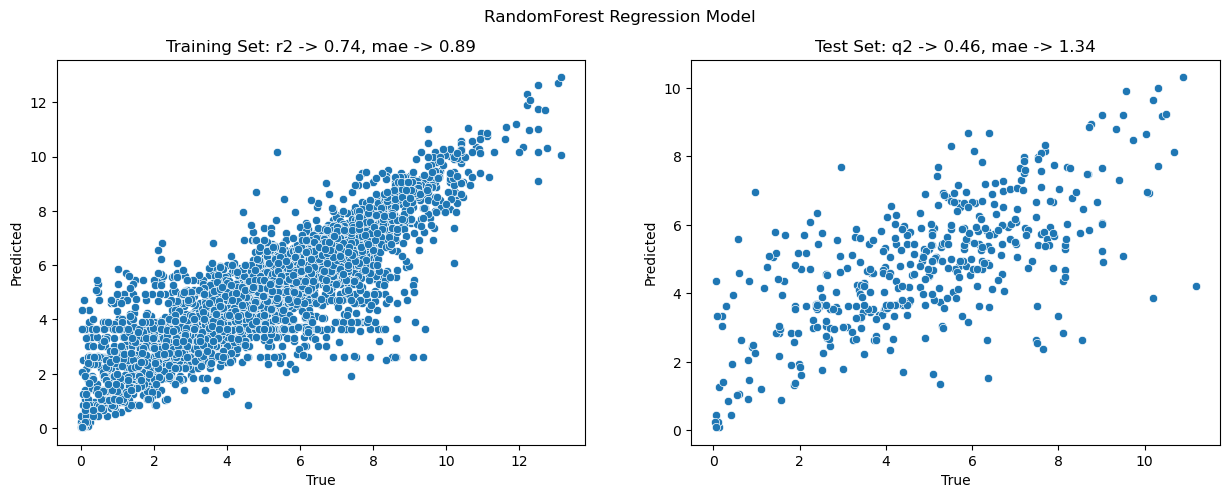

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('RandomForest Regression Model')

# Training Set Results
sns.scatterplot(ax=axes[0], data=train_df, x='True', y='Predicted')
axes[0].set_title(f"Training Set: r2 -> {round(r2,2)}, mae -> {round(train_mae, 2)}")

# Test Set Results
sns.scatterplot(ax=axes[1], data=test_df, x='True', y='Predicted')
axes[1].set_title(f"Test Set: q2 -> {round(q2, 2)}, mae -> {round(test_mae, 2)}")

In [85]:
train_permuter.importances_mean

array([3.12373507e-01, 4.95471126e-02, 1.15570960e-01, 3.92247500e-01,
       5.08117610e-01, 3.29072247e-02, 3.35659590e-03, 1.34324644e-01,
       4.45784966e-01, 9.07621766e-05, 2.70695148e-04, 8.29281859e-05,
       1.73296997e-01, 1.05474139e-04, 6.24194946e-05, 2.56185038e-04,
       1.41923946e-04, 2.13230054e-06, 2.84891569e-03, 3.72741009e-04,
       5.59565040e-04, 6.55394555e-05, 5.61521092e-04, 4.35918277e-03,
       3.88716639e-05, 2.11946203e-02, 9.53852072e-07, 1.88800855e-04,
       1.34958358e-05, 4.37038189e-04, 4.47417770e-06, 9.90474875e-05,
       5.14166895e-04, 5.68718334e-05, 1.39342408e-04, 5.78822959e-05,
       2.56055973e-05, 1.91909294e-02, 1.10888734e-02, 6.47579670e-05,
       1.17200968e-04, 5.81275423e-03, 3.31823652e-06, 7.18619757e-05,
       1.09015665e-05, 1.47472869e-03, 3.92659021e-04, 2.73736178e-05])

In [12]:
train_permuter = permutation_importance(rf_reg, X_train, Y_train, n_repeats=10)
test_permuter = permutation_importance(rf_reg, X_test, Y_test, n_repeats=10)


c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\clarkep\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be c

In [13]:

sorted_importances_idx = (-test_permuter.importances_mean).argsort()

importance_df = pd.DataFrame.from_dict({"Features": X_train.columns[sorted_importances_idx],"Train": train_permuter.importances_mean[sorted_importances_idx].T, "Test": test_permuter.importances_mean[sorted_importances_idx].T})
importance_df


,Features,Train,Test
0,Semiconductor Scattering Layer Thickness (um),0.532230,3.857643e-01
1,Active area (cm2),0.454411,3.301161e-01
2,Semiconductor Film Thickness (um),0.399319,2.680498e-01
3,Exposure time (h),0.310935,2.092943e-01
4,Electrolyte_Co(II)_Co(III),0.185482,1.220677e-01
5,Dye loading (nmol/cm2),0.118220,7.125413e-02
6,Co-adsorbent Conc. (mM),0.138179,6.587979e-02
7,Solar simulator at 1.5G (mW/cm2),0.052815,1.659759e-02
8,Used Co-sensitizer,0.041789,1.500656e-02
9,Semiconductor_TiO2,0.012007,1.322042e-02


In [14]:
dsscdb.loc[dsscdb["Electrolyte"] == "Co(II)_Co(III)"]

,VOC,JSC,FF,PCE,Electrolyte,Molecule SMILE,Exposure time (h),Solar simulator at 1.5G (mW/cm2),Dye loading (nmol/cm2),Semiconductor Type,Semiconductor Film Thickness (um),Semiconductor Scattering Layer Thickness (um),Used Co-sensitizer,Used Co-adsorbent,Co-adsorbent type,Co-adsorbent Conc. (mM),Active area (cm2)
254,615.0,14.50,0.670,6.10,Co(II)_Co(III),CCCCCCN1c2ccc(cc2Sc2c1ccc(c2)/C=c/1\s/c(=C(/C(...,12.0,100.0,152.64,TiO2,10.0,4.0,0,0,None,0.00,0.12
801,908.0,15.42,0.743,10.40,Co(II)_Co(III),CCCCCCCCC(Cn1c2cc(C#Cc3ccc(c4c3nsn4)c3ccc(cc3)...,12.0,100.0,152.64,TiO2,5.0,4.2,0,0,None,0.00,0.16
802,915.0,16.88,0.754,11.60,Co(II)_Co(III),CCCCCCCCC(Cn1c2cc(C#Cc3ccc(c4c3nsn4)c3ccc(cc3)...,12.0,100.0,152.64,TiO2,5.0,4.2,1,0,None,0.00,0.16
812,633.0,13.40,0.688,5.80,Co(II)_Co(III),CCCCCCOc1cc(OCCCCCC)ccc1c1ccc(cc1)N(c1ccc(cc1)...,12.0,100.0,152.64,TiO2,10.0,4.0,0,0,None,0.00,0.12
850,883.0,16.71,0.722,10.70,Co(II)_Co(III),CCCCCCCCC(Cn1c2cc(C#Cc3ccc(c4c3nsn4)c3ccc(cc3)...,12.0,100.0,152.64,TiO2,5.0,4.5,0,0,None,0.00,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255,745.0,17.60,0.750,9.81,Co(II)_Co(III),CCCCC(Cn1c(c2ccc(s2)c2ccc3c(c2)N(c2ccc(cc2)c2c...,15.0,100.0,152.64,TiO2,4.0,4.0,0,1,CDCA,2.50,0.20
4257,716.0,15.20,0.760,8.23,Co(II)_Co(III),CCCCC(Cn1c(=O)c2c(c1c1ccc(cc1)c1ccc(o1)C=C(C(=...,15.0,100.0,152.64,TiO2,4.0,4.0,0,1,CDCA,2.50,0.20
4354,677.0,1.49,0.810,8.60,Co(II)_Co(III),CCCCC(Cn1c(c2ccc(s2)c2ccc(cc2)N(c2ccc(cc2)OCCC...,15.0,9.5,152.64,TiO2,4.0,4.0,0,1,CDCA,2.50,0.20
4355,743.0,15.60,0.780,8.97,Co(II)_Co(III),CCCCC(Cn1c(c2ccc(s2)c2ccc(cc2)N(c2ccc(cc2)OCCC...,15.0,100.0,152.64,TiO2,4.0,4.0,0,1,CDCA,1.25,0.20


<Axes: xlabel='Test', ylabel='Features'>

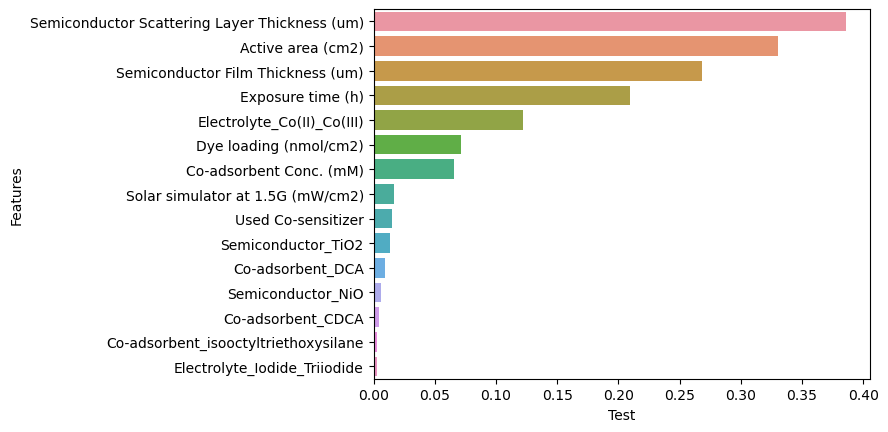

In [15]:
sns.barplot(data=importance_df.head(15), y="Features", x="Test")

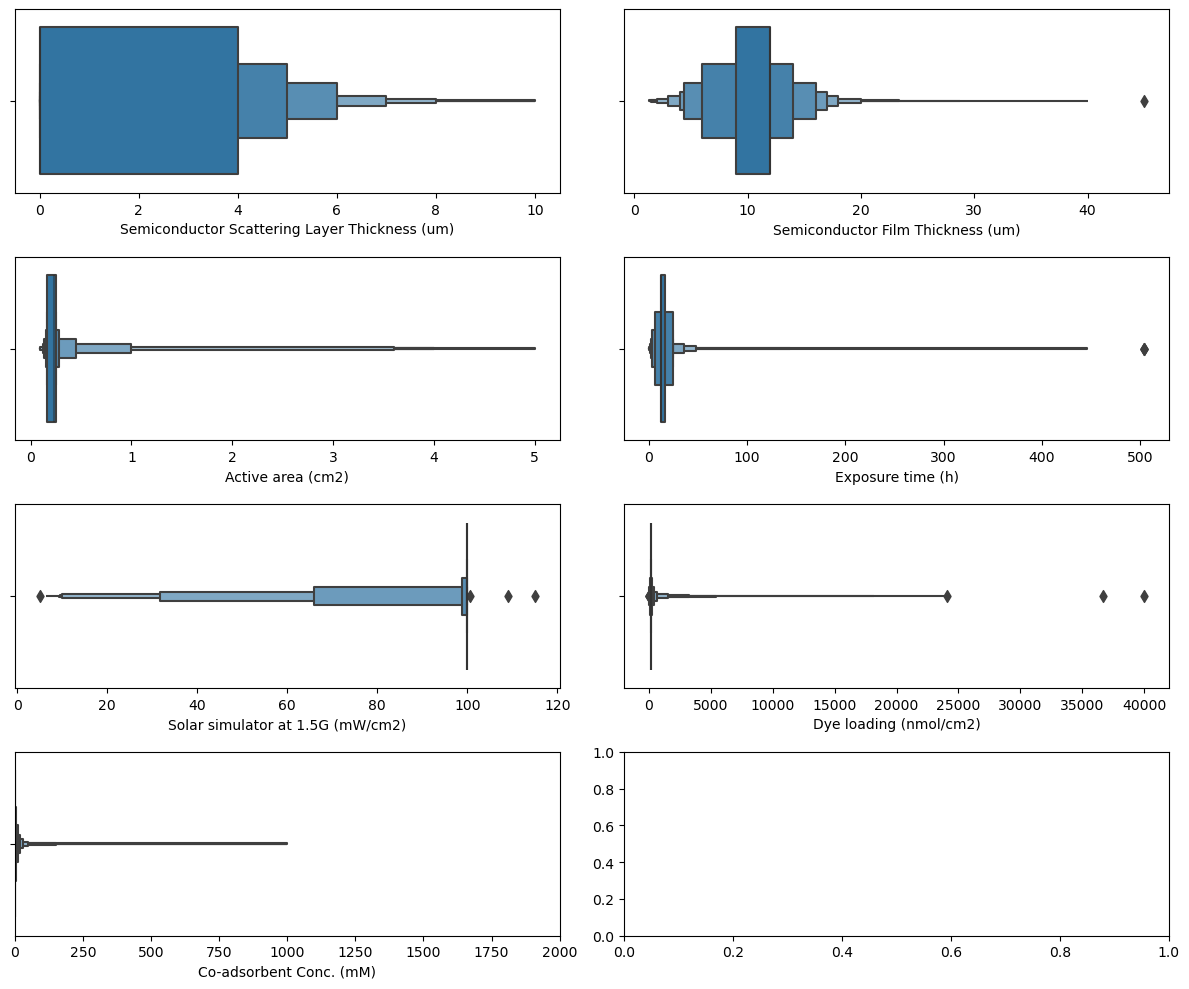

In [159]:
fig, axes = plt.subplots(4,2, figsize=(12,10))
sns.boxenplot(ax=axes[0,0], data=dsscdb, x="Semiconductor Scattering Layer Thickness (um)", k_depth='trustworthy')
sns.boxenplot(ax=axes[0,1], data=dsscdb, x="Semiconductor Film Thickness (um)", k_depth='trustworthy')
sns.boxenplot(ax=axes[1,0], data=dsscdb, x="Active area (cm2)", k_depth='trustworthy')
sns.boxenplot(ax=axes[1,1], data=dsscdb, x="Exposure time (h)", k_depth='trustworthy')
sns.boxenplot(ax=axes[2,0], data=dsscdb, x="Solar simulator at 1.5G (mW/cm2)", k_depth='trustworthy')
sns.boxenplot(ax=axes[2,1], data=dsscdb, x= "Dye loading (nmol/cm2)", k_depth='trustworthy')
sns.boxenplot(ax=axes[3,0], data=dsscdb, x="Co-adsorbent Conc. (mM)", k_depth='trustworthy').set(xlim=(0,2000))

plt.tight_layout()

<Axes: xlabel='Semiconductor Scattering Layer Thickness (um)', ylabel='PCE'>

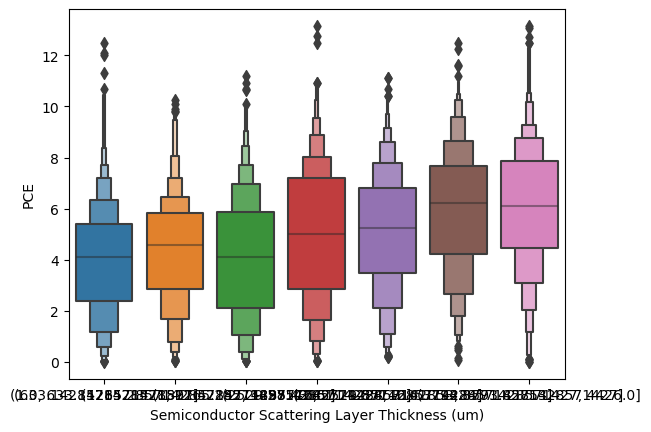

In [57]:
examine_pce = pd.concat([device_descs_cat_ohe["Semiconductor Scattering Layer Thickness (um)"], dsscdb["PCE"]], axis=1)

sns.boxenplot(data=examine_pce, x="Semiconductor Scattering Layer Thickness (um)", y="PCE")

In [34]:
to_ohe = ["Semiconductor Film Thickness (um)", "Semiconductor Scattering Layer Thickness (um)", "Active area (cm2)", "Exposure time (h)", "Solar simulator at 1.5G (mW/cm2)", "Dye loading (nmol/cm2)", "Co-adsorbent Conc. (mM)"]

In [99]:
device_descs_cat_ohe = pd.read_csv("DBVersions/categorical_ohe.csv", index_col=0)

In [100]:
device_descs_cat_ohe["Semiconductor Scattering Layer Thickness (um)"] = pd.qcut(device_descs_cat_ohe["Semiconductor Scattering Layer Thickness (um)"].rank(method='first'), q=7, precision=3, duplicates='drop')
device_descs_cat_ohe["Semiconductor Film Thickness (um)"] = pd.qcut(device_descs_cat_ohe["Semiconductor Film Thickness (um)"].rank(method='first'), q=16, precision=3, duplicates='drop')
device_descs_cat_ohe["Active area (cm2)"] = pd.qcut(device_descs_cat_ohe["Active area (cm2)"].rank(method='first'), q=13, precision=3, duplicates='drop')
device_descs_cat_ohe["Exposure time (h)"] = pd.qcut(device_descs_cat_ohe["Exposure time (h)"].rank(method='first'), q=12, precision=3, duplicates='drop')
device_descs_cat_ohe["Solar simulator at 1.5G (mW/cm2)"] = pd.qcut(device_descs_cat_ohe["Solar simulator at 1.5G (mW/cm2)"].rank(method='first'), q=9, precision=3, duplicates='drop')
device_descs_cat_ohe["Dye loading (nmol/cm2)"] = pd.qcut(device_descs_cat_ohe["Dye loading (nmol/cm2)"].rank(method='first'), q=10, precision=3, duplicates='drop')
device_descs_cat_ohe["Co-adsorbent Conc. (mM)"] = pd.qcut(device_descs_cat_ohe["Co-adsorbent Conc. (mM)"].rank(method='first'), q=9, precision=3, duplicates='drop')

device_descs_cat_ohe

,Exposure time (h),Solar simulator at 1.5G (mW/cm2),Dye loading (nmol/cm2),Semiconductor Film Thickness (um),Semiconductor Scattering Layer Thickness (um),Used Co-sensitizer,Used Co-adsorbent,Co-adsorbent Conc. (mM),Active area (cm2),Electrolyte_0.005 M isopropanol solution of H2PtCl6·6H2O,...,Co-adsorbent_DCA,Co-adsorbent_DINHOP,Co-adsorbent_HC-A,Co-adsorbent_None,Co-adsorbent_cholanic acid,Co-adsorbent_cholic acid,Co-adsorbent_diphenyphosphinic acid,Co-adsorbent_isooctyltriethoxysilane,Co-adsorbent_isooctyltrimethoxysilane,Co-adsorbent_octanoic acid
0,"(2951.0, 3319.75]","(0.999, 492.667]","(443.5, 886.0]","(1660.375, 1936.938]","(0.999, 633.143]",0,0,"(0.999, 492.667]","(2043.308, 2383.692]",0,...,0,0,0,1,0,0,0,0,0,0
1,"(369.75, 738.5]","(0.999, 492.667]","(443.5, 886.0]","(554.125, 830.688]","(3161.714, 3793.857]",0,0,"(0.999, 492.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
2,"(369.75, 738.5]","(0.999, 492.667]","(443.5, 886.0]","(554.125, 830.688]","(3161.714, 3793.857]",0,0,"(0.999, 492.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
3,"(369.75, 738.5]","(0.999, 492.667]","(443.5, 886.0]","(554.125, 830.688]","(3161.714, 3793.857]",0,0,"(0.999, 492.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
4,"(369.75, 738.5]","(0.999, 492.667]","(443.5, 886.0]","(554.125, 830.688]","(3161.714, 3793.857]",0,0,"(0.999, 492.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,"(4057.25, 4426.0]","(3934.333, 4426.0]","(3983.5, 4426.0]","(3872.875, 4149.438]","(1897.429, 2529.571]",0,0,"(2951.0, 3442.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
4422,"(4057.25, 4426.0]","(3934.333, 4426.0]","(3983.5, 4426.0]","(3872.875, 4149.438]","(2529.571, 3161.714]",0,0,"(2951.0, 3442.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
4423,"(4057.25, 4426.0]","(3934.333, 4426.0]","(3983.5, 4426.0]","(3872.875, 4149.438]","(2529.571, 3161.714]",0,0,"(2951.0, 3442.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0
4424,"(4057.25, 4426.0]","(3934.333, 4426.0]","(3983.5, 4426.0]","(3872.875, 4149.438]","(2529.571, 3161.714]",0,0,"(2951.0, 3442.667]","(0.999, 341.385]",0,...,0,0,0,1,0,0,0,0,0,0


In [101]:
device_descs_cat_ohe.to_csv("DBVersions/con_to_cat.csv")

In [102]:
for desc in to_ohe:
    desc_ohe = pd.get_dummies(device_descs_cat_ohe[desc], prefix=desc)
    device_descs_cat_ohe = pd.concat([device_descs_cat_ohe, desc_ohe], axis='columns')

In [103]:
fp_device_desc = device_descs_cat_ohe.drop(to_ohe, axis='columns')
fp_device_desc

,Used Co-sensitizer,Used Co-adsorbent,Electrolyte_0.005 M isopropanol solution of H2PtCl6·6H2O,Electrolyte_AN-50,Electrolyte_Bromide_Tribromide,Electrolyte_Co(II)_Co(III),Electrolyte_Cu(I)_Cu(II),"Electrolyte_DHS-Z23, Heptachroma",Electrolyte_DMPIC_DMPIDC,Electrolyte_Dyesol Mixes,...,"Dye loading (nmol/cm2)_(3983.5, 4426.0]","Co-adsorbent Conc. (mM)_(0.999, 492.667]","Co-adsorbent Conc. (mM)_(492.667, 984.333]","Co-adsorbent Conc. (mM)_(984.333, 1476.0]","Co-adsorbent Conc. (mM)_(1476.0, 1967.667]","Co-adsorbent Conc. (mM)_(1967.667, 2459.333]","Co-adsorbent Conc. (mM)_(2459.333, 2951.0]","Co-adsorbent Conc. (mM)_(2951.0, 3442.667]","Co-adsorbent Conc. (mM)_(3442.667, 3934.333]","Co-adsorbent Conc. (mM)_(3934.333, 4426.0]"
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4422,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4423,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4424,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [104]:
fp_device_desc.to_csv("DBVersions/device_fp.csv")

In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(fp_device_desc, device_props["PCE"], test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, Y_train)

pred_train = rf_reg.predict(X_train)
pred_test = rf_reg.predict(X_test)

train_df = pd.DataFrame.from_dict({'True': Y_train, 'Predicted': pred_train})
test_df = pd.DataFrame.from_dict({'True': Y_test, 'Predicted': pred_test})


# ---- train results ----
r2 = r2_score(Y_train, pred_train)
train_mae = mean_absolute_error(Y_train, pred_train)

# ---- test results ----
q2 = r2_score(Y_test, pred_test)
test_mae = mean_absolute_error(Y_test, pred_test)

Text(0.5, 1.0, 'Test Set: q2 -> 0.58, mae -> 1.18')

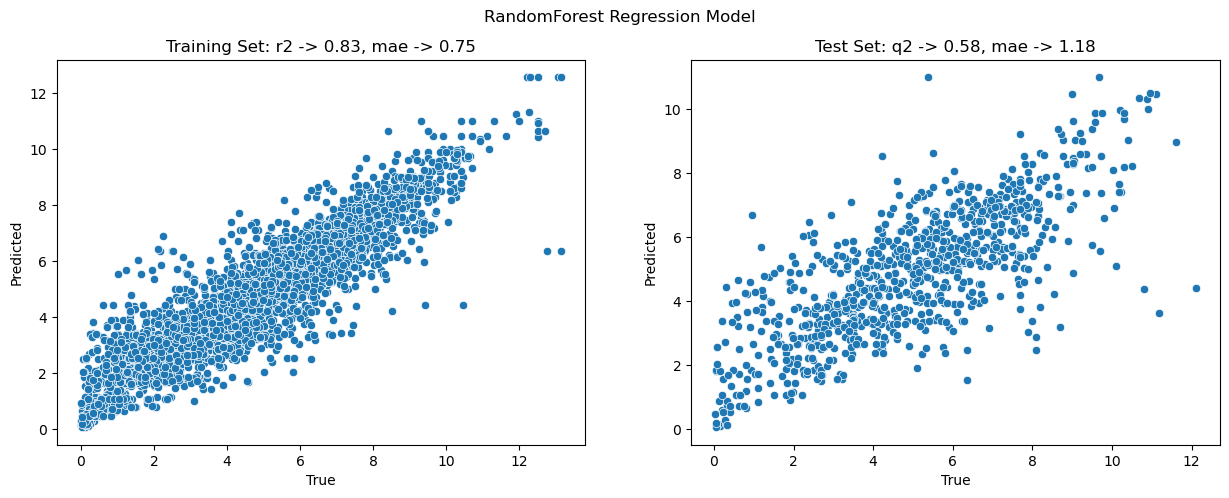

In [118]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('RandomForest Regression Model')

# Training Set Results
sns.scatterplot(ax=axes[0], data=train_df, x='True', y='Predicted')
axes[0].set_title(f"Training Set: r2 -> {round(r2,2)}, mae -> {round(train_mae, 2)}")

# Test Set Results
sns.scatterplot(ax=axes[1], data=test_df, x='True', y='Predicted')
axes[1].set_title(f"Test Set: q2 -> {round(q2, 2)}, mae -> {round(test_mae, 2)}")

<Axes: xlabel='Test', ylabel='Features'>

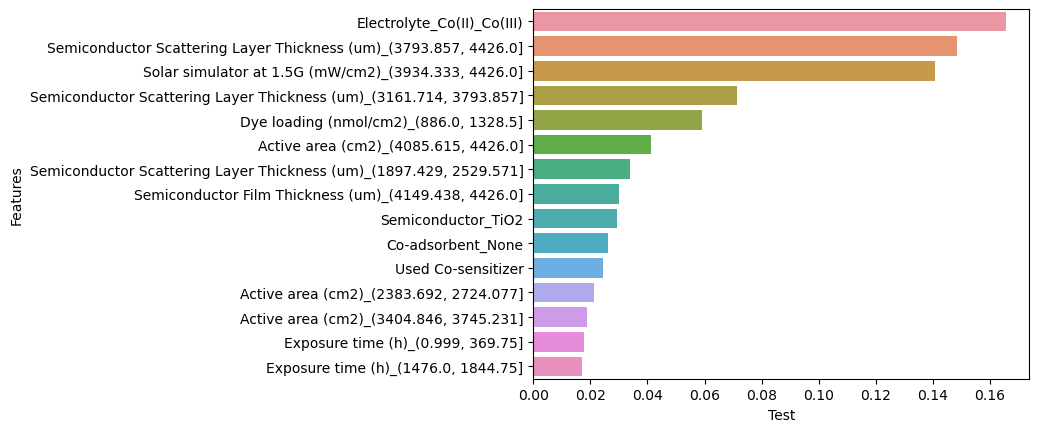

In [110]:
train_permuter = permutation_importance(rf_reg, X_train, Y_train, n_repeats=10)
test_permuter = permutation_importance(rf_reg, X_test, Y_test, n_repeats=10)

sorted_importances_idx = (-test_permuter.importances_mean).argsort()

importance_df = pd.DataFrame.from_dict({"Features": X_train.columns[sorted_importances_idx],"Train": train_permuter.importances_mean[sorted_importances_idx].T, "Test": test_permuter.importances_mean[sorted_importances_idx].T})

sns.barplot(data=importance_df.head(15), y="Features", x="Test")